# Binary Classification of Chest X-ray Images by
# ** By Y. Kostrov
***

![xray](../images/first.png)

***
# Overview
## In this project, I create a model that will classify x-ray image of a chest as the one that has pneumonia or the one that doesn't have pneumonia.

## During the analysis:
## 1.  I will perform the necessary data wrangling first.
## 2. I will build a Baseline Model from scratch.
> * ##   I will check the performance of the baseline model.
## 3.  I will build a Transfer Learning Model based on the VGG19 architecture.
>  *   ## I will check the performance of the transfer learning model.
## 4. I will compare the results of the beforementioned models to choose the better of the two.

***
# Business Problem
## Pneumonia is a very dangerous diseases that is caused by a bacterial or viral infection of the lungs. The consequences of pneumonia could be catastrophic within a short period of time if not diagnosed quickly. Two years ago my father was addmitted into an emergency room with pneumonia, but doctors in the emergency facilities could not find pneumonia in the x-ray images, eventually they needed help of the expert and it took them about 8 hours to figure the cause of the diseas. It would be great to design a system of automatic diagnosis, capable of analyzing X-rays and help the pneumonia detection on early stages. In this project I will develop two models for the classification of chest X-ray images into NORMAL (no pneumonia) vs. PNEUMONIA(there is pneumonia in the lungs). I will recommend the model that has a better performance.

***
# Metrics for Assessement of Models:
## 1. The primary metric for my analysis will be recall.
> * ##   Recall is defined as: a number of True Positives divided by the number of Total Actual Positives.
> * ##   Thus Recall is a better model metric when there is a high cost associated with False Negative.
> * ##   In our case False Negative is predicting images as ”NORMAL” when in reality the image has the label ”PNEUMONIA”. 
> * ##   In this case pneumonia will not be diagnosed in the patient and consequnces might be drastic.

## 2. The secondary metric will be accuracy.
> * ## deepai.org defines accuracy as follows:"The accuracy of a machine learning classification algorithm is one way to measure how often the algorithm classifies a data point correctly. Accuracy is the number of correctly predicted data points out of all the data points. More formally, it is defined as the number of true positives and true negatives divided by the number of true positives, true negatives, false positives, and false negatives. A true positive or true negative is a data point that the algorithm correctly classified as true or false, respectively. A false positive or false negative, on the other hand, is a data point that the algorithm incorrectly classified. For example, if the algorithm classified a false data point as true, it would be a false positive. Often, accuracy is used along with precision and recall, which are other metrics that use various ratios of true/false positives/negatives. Together, these metrics provide a detailed look at how the algorithm is classifying data points." 



***
# Data Description
* ## Data for this project was downloaded from [Mendeley Data: Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj/3). 
* ## Data consists of chest x-ray images located in two directories: train with images for training a model  and test with images for testing a model at the end.
* ## Images in the directory are of different size so the have to be regularized before training and testing.


# Cleaning/Modifying Data:
* ## I deleted one file in the training set that had incompatible label.
* ## I put the paths to the files and labels into dataframe so it would be easier to create Data Generators and, also, would beeasier to test my models.
* ## I used preprocessing function from Keras/VGG19 model to bring pictures to the same shape and form for training and testing.

***
## Importing all needed packages
***

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

***
## Define help functions
***

In [5]:
def img_class(cl)->int:
    """
    Inputs:
    cl --> a real number between 0 and 1.
    Output:
    if cl is closer to 1 --> 1
    if cl is closer to 0 --> 0
    """
    if np.round(cl[0]) == 1:
        return 0
    else:
        return 1 

## Set global constants

In [6]:
IMAGES_LOCATION = "/home/kostrovy/data/x_ray/train" # location of images for training
TEST_IMAGES = "/home/kostrovy/data/x_ray/test" # location of images for testing
IMG_HEIGHT= 224 # set image height
IMG_WIDTH = 224 # set image size
BATCH_SIZE = 16 # set batch size

In [7]:
# Collect the paths for files used for training
files =[]
for r, d, f in os.walk(IMAGES_LOCATION):
    for file in f:
        files.append(os.path.join(r,file))

In [8]:
# Create dataframe with images for trainging to use in the Data Generator
images = pd.DataFrame(files) # dataframe
images.columns = ['path'] # set name for the column with 'path'
images['label'] = images.path.apply(lambda x:x.split('/')[-2] ) # create column with labels for each image

In [9]:
# check the shape 
images.shape #  There are 5233 images in total for training.

(5233, 2)

In [10]:
images.label.unique() # check the unique values I have in the data.

array(['train', 'NORMAL', 'PNEUMONIA'], dtype=object)

In [11]:
# somehow we have label 'train', so I will remove it.
images.drop(images[images.label=='train'].index, axis=0, inplace=True)

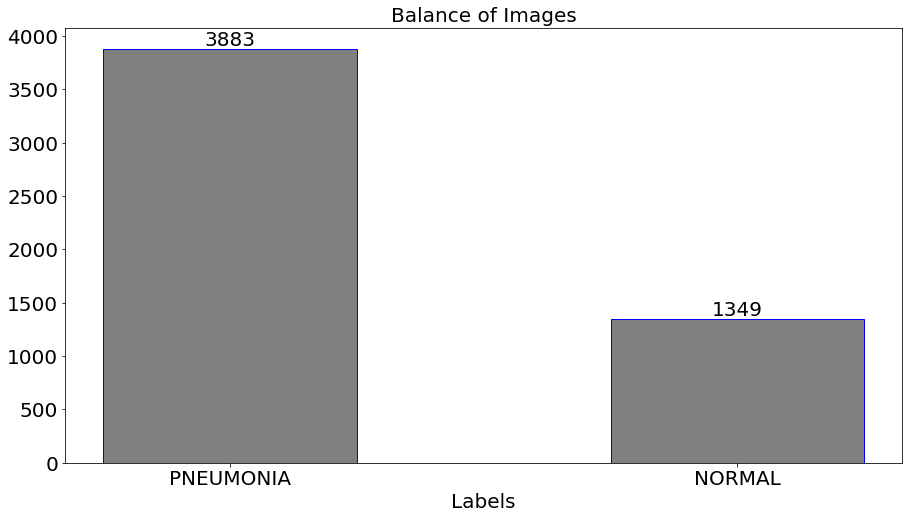

In [12]:
# Check the balance of labels in the histogram
counts = images.label.value_counts()
labels = list(counts.keys())
totals = [counts[key] for key in labels]
plt.figure(figsize=(15,8))
plt.bar(labels, totals, width= 0.5, align='center',color='gray', edgecolor = 'blue')
plt.xlabel("Labels", fontsize=20)
# Annotating the bar plot with the values (total death count)
j = 30
for i in range(len(labels)):
    plt.annotate(totals[i], ( i - 0.05, totals[i] + j),fontsize=20)
plt.title("Balance of Images")
plt.savefig("../images/second.png")
plt.show()



# Comments on training data
 There are 5233 images in train folder: 3883 "pneumonia" and 1349 "normal" (one file was corrupted and I deleted it).
# There are more images with pnemonia in this data set but the disproportion is not crazy bad
***

***
# Let's look at some pictures of normal lungs  vs lungs with pneumonia.

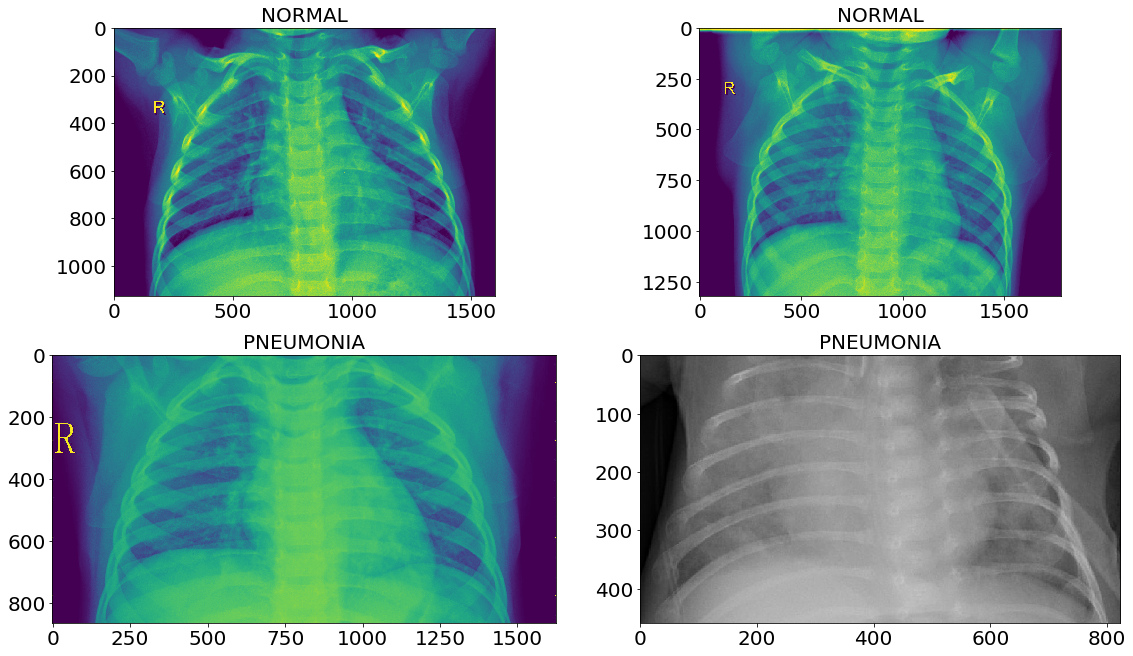

In [16]:
fig, axs = plt.subplots(2, 2,figsize=(16,9), constrained_layout=True)
for i in [0,1]:
    normal_df = images[images.label=='NORMAL']
    numb= np.random.randint(0,normal_df.shape[0])
    img = plt.imread(normal_df.loc[numb]['path'])
    axs[0,i].imshow(img)
    axs[0,i].set_title(normal_df.loc[numb]['label'])
for i in [0,1]:
    pnem_df = images[images.label=='PNEUMONIA']
    numb= np.random.randint(0,pnem_df.shape[0])
    img = plt.imread(pnem_df.loc[numb]['path'])
    axs[1,i].imshow(img)
    axs[1,i].set_title(pnem_df.loc[numb]['label'])
plt.savefig("../images/third.png")
plt.show()

In [17]:
# Split the data frame into training and validation sets
df_train, df_test = train_test_split(images, random_state=42)
print(df_train.shape, df_test.shape)

(3924, 2) (1308, 2)


# CREATE THE SET OF TEST FILES FOR FINAL TESTING 

In [18]:
# Collect the paths for files used for training
files =[]
for r, d, f in os.walk(TEST_IMAGES):
    for file in f:
        files.append(os.path.join(r,file))

In [19]:
# check how many files we have
len(files)

625

In [20]:
# Create dataframe with images for testing to use in the Data Generator
test_files =[]
for r, d, f in os.walk(TEST_IMAGES):
    for file in f:
        test_files.append(os.path.join(r,file))
test_images = pd.DataFrame(test_files)
test_images.columns = ['path']
test_images['label'] = test_images.path.apply(lambda x: x.split('/')[-2] )
test_images.drop(0, axis=0,inplace=True) # the first image is corrupted so drop it
test_images.loc[1,'path']
img = mpimg.imread(test_images.loc[2,'path'])

In [21]:
# Check if everything went well.
test_images.label.unique()

array(['NORMAL', 'PNEUMONIA'], dtype=object)

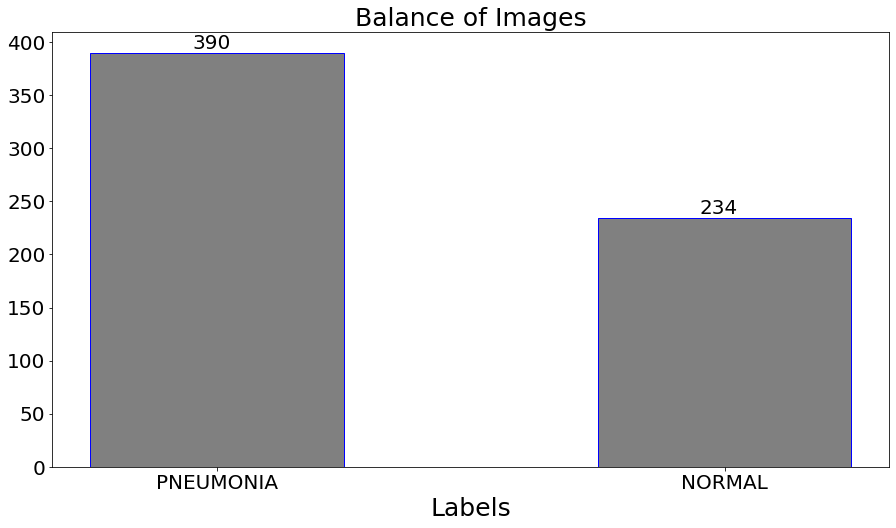

In [22]:
# Check the balance of labels in the histogram
counts = test_images.label.value_counts()
labels = list(counts.keys())
totals = [counts[key] for key in labels]
plt.figure(figsize=(15,8))
plt.bar(labels, totals, width= 0.5, align='center',color='gray', edgecolor = 'blue')
plt.xlabel("Labels", fontsize=25)
# Annotating the bar plot with the values (total death count)
for i in range(len(labels)):
    plt.annotate(totals[i], ( i - 0.05, totals[i] + 4),fontsize=20)
plt.title("Balance of Images", fontsize=25)
plt.savefig("../images/fourth.png")
plt.show()


# Comments on testing images
* ## There are 625 images in test folder: 390 "pneumonia" and 234 "normal"
* ## Testing images have a better balance of "pneumonia" vs "normal".
***

***
# Let's look at some pictures of normal lungs  vs lungs with pneumonia in the testing set.

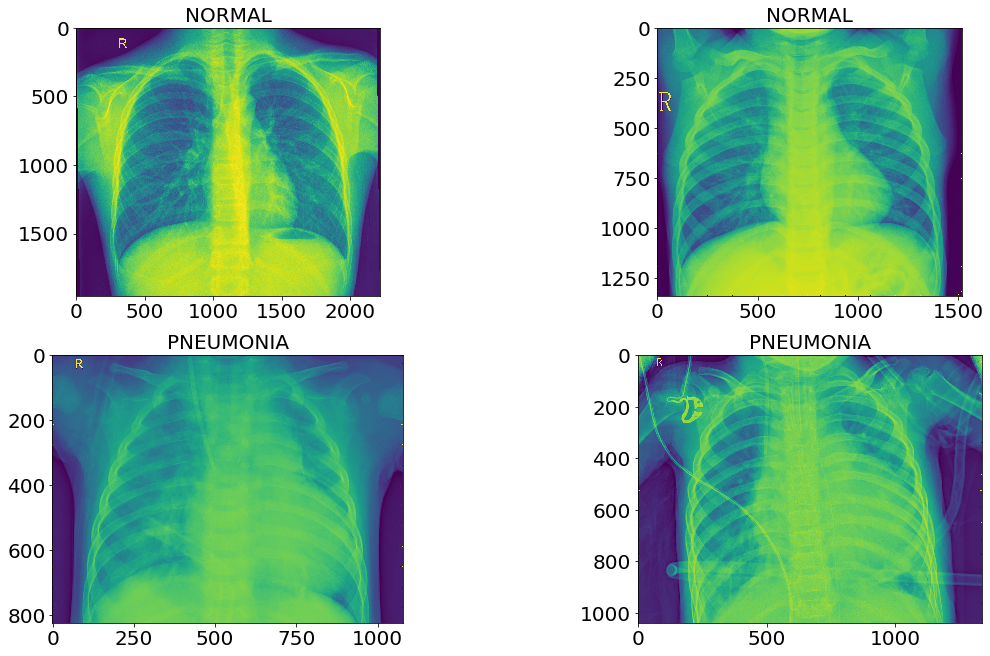

In [38]:
fig, axs = plt.subplots(2, 2,figsize=(16,9), constrained_layout=True)
for i in [0,1]:
    tnormal_df = test_images[test_images.label=='NORMAL']
    numb= np.random.randint(0,tnormal_df.shape[0])
    img = plt.imread(tnormal_df.loc[numb]['path'])
    axs[0,i].imshow(img)
    axs[0,i].set_title(tnormal_df.loc[numb]['label'])
for i in [0,1]:
    tpnem_df = test_images[test_images.label=='PNEUMONIA']
    numb= np.random.randint(0,tpnem_df.shape[0])
    img = plt.imread(tpnem_df.loc[numb]['path'])
    axs[1,i].imshow(img)
    axs[1,i].set_title(tpnem_df.loc[numb]['label'])
plt.savefig("../images/fifth.png")
plt.show()

In [39]:
test_images.label.unique()

array(['NORMAL', 'PNEUMONIA'], dtype=object)

***
## Create image generator for training. For regularization purposes I use image augmentation in training set to avoid overfitting.
***

In [41]:
datagen_train = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 8,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    )

train_generator=datagen_train.flow_from_dataframe(
dataframe=df_train,
x_col="path",
y_col="label",
batch_size=BATCH_SIZE,
seed=42,
target_size=(IMG_HEIGHT,IMG_HEIGHT)
)

Found 3924 validated image filenames belonging to 2 classes.


***
## Create image generator for validation during the training process
***

In [42]:
datagen_valid = ImageDataGenerator(
    preprocessing_function = preprocess_input
)


valid_generator=datagen_valid.flow_from_dataframe(
dataframe=df_test,
x_col = "path",
y_col = "label",
batch_size = BATCH_SIZE,
seed = 42,
target_size = (IMG_HEIGHT,IMG_HEIGHT)
)

Found 1308 validated image filenames belonging to 2 classes.


***
## Create image generator for final testing at the end of the training cycle
***

In [43]:
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_img_generator=datagen_test.flow_from_directory(
    TEST_IMAGES, 
    batch_size=624,
    target_size=(IMG_HEIGHT,IMG_HEIGHT),
    seed=42)

Found 624 images belonging to 2 classes.


***
## Create baseline model and train it from scratch
***

In [44]:
new_model = Sequential()
new_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3)))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(2,activation='softmax'))

***
# Set "recall" to be the primary metric and the "accuracy" to be the secondary metric
***

In [45]:
metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()]
new_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=metrics) # use SGD as optimizer

In [46]:
EPOCHS = 30 #set number of epochs
STEPS_PER_EPOCH = 128 # set the number of steps per epochs for training
VALIDATION_STEPS = 64 # set the number of steps per epoch for validation
history = new_model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS) # train

Epoch 1/30
128/128 [==============================] - 36s 257ms/step - loss: 4.7434 - recall: 0.6743 - accuracy: 0.0000e+00 - val_loss: 4.4224 - val_recall: 0.7266 - val_accuracy: 0.0000e+00
Epoch 2/30
128/128 [==============================] - 32s 250ms/step - loss: 4.3907 - recall: 0.7346 - accuracy: 0.0000e+00 - val_loss: 4.3288 - val_recall: 0.7256 - val_accuracy: 0.0000e+00
Epoch 3/30
128/128 [==============================] - 32s 250ms/step - loss: 4.3116 - recall: 0.7719 - accuracy: 0.0000e+00 - val_loss: 4.1975 - val_recall: 0.8184 - val_accuracy: 0.0000e+00
Epoch 4/30
128/128 [==============================] - 31s 243ms/step - loss: 4.2293 - recall: 0.8056 - accuracy: 0.0000e+00 - val_loss: 4.1216 - val_recall: 0.8867 - val_accuracy: 0.0000e+00
Epoch 5/30
128/128 [==============================] - 32s 248ms/step - loss: 4.1874 - recall: 0.8094 - accuracy: 0.0000e+00 - val_loss: 4.0404 - val_recall: 0.9297 - val_accuracy: 0.0000e+00
Epoch 6/30
128/128 [=========================

***
## Create a plot of Training & Validation Recalls and Traininig & Validations Loss
***

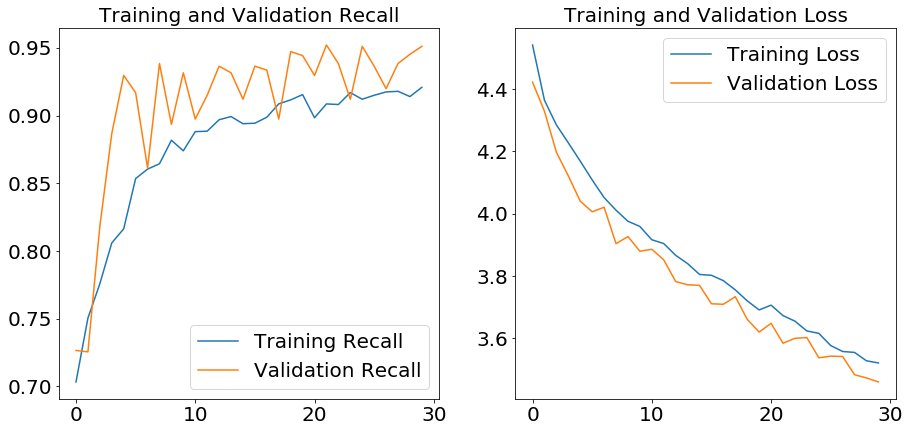

In [47]:
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("../images/sixth.png")
plt.show()

***
# Let's use testing images to verify our results
***

In [49]:
preds = None
true_y = None
for i,j in test_img_generator:
    preds = np.round(new_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
one_class_preds = [img_class(i) for i in preds]

print("Confusion Matrix:\n ", confusion_matrix(one_class_true_y, one_class_preds))
print("Recall Score: \n", recall_score(one_class_true_y, one_class_preds))
print("Accuracy Score: \n", accuracy_score(one_class_true_y, one_class_preds))

Confusion Matrix:
  [[160  74]
 [  4 386]]
Recall Score: 
 0.9897435897435898
Accuracy Score: 
 0.875


***
## Let's try to use "transfer learning" since I don't have a lot of images for training, this technique should work well.
***

In [50]:
# set the base mode to VGG19
base_model = VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))

In [51]:
# add top layers
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(units=512,activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
transfer_model = Model(inputs = base_model.input, outputs=predictions)

In [52]:
transfer_model.summary() # print out the summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [53]:
# Fix layers for the base model as non-trainable
base_model.trainable = False

In [54]:
transfer_model.compile(optimizer=SGD(lr = 0.0001, momentum = 0.9),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                    metrics = metrics) # compile the model

In [55]:
# Train the top layers for 10 epochs to "warm" them up
EPOCHS = 10
STEPS_PER_EPOCH = 200
VALIDATION_STEPS = 32
transfer_history = transfer_model.fit(train_generator,epochs = EPOCHS,
            steps_per_epoch = STEPS_PER_EPOCH,
            validation_data = valid_generator,
            validation_steps = VALIDATION_STEPS)

Epoch 1/10
200/200 [==============================] - 45s 218ms/step - loss: 0.9076 - recall: 0.8319 - accuracy: 0.0023 - val_loss: 0.2280 - val_recall: 0.9141 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 42s 211ms/step - loss: 0.4511 - recall: 0.8566 - accuracy: 0.0282 - val_loss: 0.2348 - val_recall: 0.9062 - val_accuracy: 0.0029
Epoch 3/10
200/200 [==============================] - 42s 212ms/step - loss: 0.3793 - recall: 0.8650 - accuracy: 0.0436 - val_loss: 0.1615 - val_recall: 0.9258 - val_accuracy: 0.0195
Epoch 4/10
200/200 [==============================] - 43s 216ms/step - loss: 0.3536 - recall: 0.8829 - accuracy: 0.0524 - val_loss: 0.2187 - val_recall: 0.9082 - val_accuracy: 0.0068
Epoch 5/10
200/200 [==============================] - 43s 218ms/step - loss: 0.3168 - recall: 0.8855 - accuracy: 0.0546 - val_loss: 0.1926 - val_recall: 0.9238 - val_accuracy: 0.0107
Epoch 6/10
200/200 [==============================] - 43s 215ms/step - loss: 0.30

***
## Below, I am going to vizualize training progress by plotting training and validation recall scores and training and validation loss.

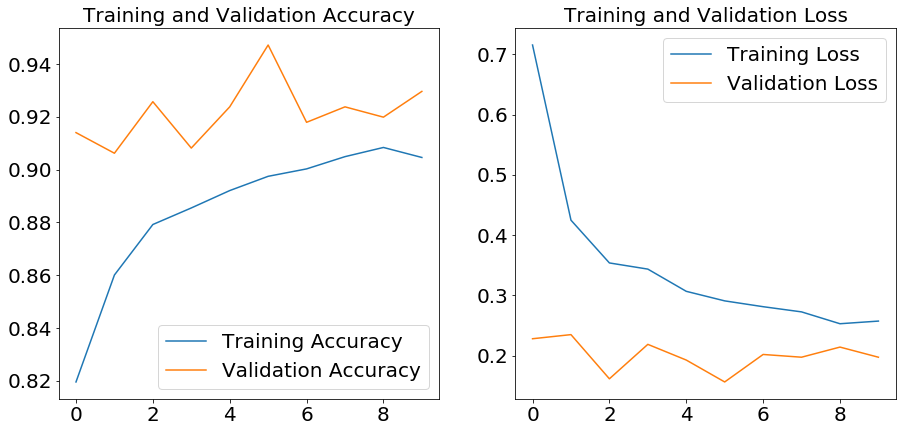

In [56]:
recall = transfer_history.history['recall']
val_recall = transfer_history.history['val_recall']
loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, recall, label='Training Accuracy')
plt.plot(epochs_range, val_recall, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig("../images/seventh.png")
plt.show()

## Before I continue, let's test the model

In [57]:
preds = None
true_y = None
for i,j in test_img_generator:
    preds = np.round(transfer_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
one_class_preds = [img_class(i) for i in preds]

print("Confusion Matrix:\n ", confusion_matrix(one_class_true_y, one_class_preds))
print("Recall Score: \n", recall_score(one_class_true_y, one_class_preds))
print("Accuracy Score: \n", accuracy_score(one_class_true_y, one_class_preds))

Confusion Matrix:
  [[215  19]
 [ 20 370]]
Recall Score: 
 0.9487179487179487
Accuracy Score: 
 0.9375


## Now we un-freeze the layers and train the whole model for 20 epochs

In [58]:
base_model.trainable = True
transfer_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [59]:
# Train the whole model for 20 epochs
EPOCHS = 20
history = transfer_model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)

Epoch 1/20
200/200 [==============================] - 45s 218ms/step - loss: 0.2289 - recall: 0.9219 - accuracy: 0.0496 - val_loss: 0.2152 - val_recall: 0.9258 - val_accuracy: 0.0430
Epoch 2/20
200/200 [==============================] - 43s 214ms/step - loss: 0.1378 - recall: 0.9577 - accuracy: 0.1036 - val_loss: 0.0977 - val_recall: 0.9648 - val_accuracy: 0.1143
Epoch 3/20
200/200 [==============================] - 43s 214ms/step - loss: 0.0973 - recall: 0.9664 - accuracy: 0.1580 - val_loss: 0.0770 - val_recall: 0.9707 - val_accuracy: 0.1914
Epoch 4/20
200/200 [==============================] - 43s 214ms/step - loss: 0.1116 - recall: 0.9628 - accuracy: 0.1607 - val_loss: 0.1215 - val_recall: 0.9551 - val_accuracy: 0.1748
Epoch 5/20
200/200 [==============================] - 43s 215ms/step - loss: 0.0814 - recall: 0.9723 - accuracy: 0.1884 - val_loss: 0.0955 - val_recall: 0.9629 - val_accuracy: 0.1973
Epoch 6/20
200/200 [==============================] - 43s 214ms/step - loss: 0.0729 -

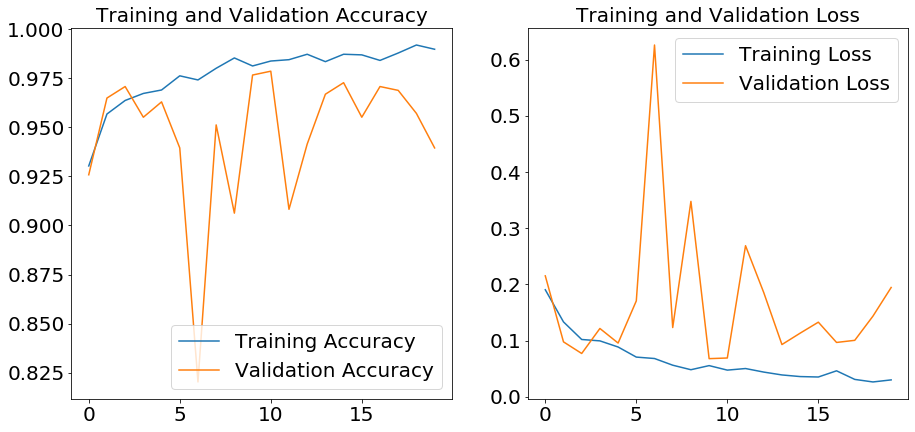

In [60]:
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, recall, label = 'Training Accuracy')
plt.plot(epochs_range, val_recall, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('../images/eighth.png')
plt.show()

In [61]:
preds = None
true_y = None
for i, j in test_img_generator:
    preds = np.round(transfer_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
one_class_preds = [img_class(i) for i in preds]


print("Confusion Matrix:\n ", confusion_matrix(one_class_true_y, one_class_preds))
print("Recall Score: \n", recall_score(one_class_true_y, one_class_preds))
print("Accuracy Score: \n", accuracy_score(one_class_true_y, one_class_preds))

Confusion Matrix:
  [[229   5]
 [ 10 380]]
Recall Score: 
 0.9743589743589743
Accuracy Score: 
 0.9759615384615384


***
# Conclusion
***

# Modeling
* ## Transfer Learning model based on VGG19 performed slightly better based on both metrics, getting recall score of 97.4% and accuracy of 97.6% compared to the baseline model that achieved the recall score of 99% and accuracy score of 87.5%.
* ## Both models performed really well.

# Business decision:
## **Based on my analysis, I suggest to use transfer learning model for detection of pneumonia in the x-ray images. It can help doctors to detect pneumonia faster with high accuracy according to the scores we have from testing set of images. I have to add, that more testing is required to be sure that the model preforms well.**

# Ways to improve the project:
* ## One way would be to build custom model taylored towards our particular set of images.
* ## Another way, would be to use another model for transfer learning.
* ## Find more extensive data set  with chest x-ray images.